## Hipótese: algumas categorias de produto apresentam maior taxa de recorrência do que outras

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.display import display, Markdown

### Carregamento dos dados

In [2]:
all_orders = pd.read_csv("../datasets/trusted/all_orders.csv")
all_orders.count()

Unnamed: 0                       99441
order_id                         99441
customer_unique_id               99441
customer_city                    99441
customer_state                   99441
order_approved_at                99281
order_purchase_timestamp         99441
order_estimated_delivery_date    99441
order_delivered_carrier_date     97658
order_delivered_customer_date    96476
dtype: int64

In [3]:
more_than_once = pd.read_csv("../datasets/trusted/more_than_once.csv")
more_than_once.count()

Unnamed: 0                       2997
order_id                         2997
customer_unique_id               2997
customer_city                    2997
customer_state                   2997
order_approved_at                2992
order_purchase_timestamp         2997
order_estimated_delivery_date    2997
order_delivered_carrier_date     2953
order_delivered_customer_date    2917
dtype: int64

### Análise por categoria

In [4]:
products = pd.read_csv('../datasets/trusted/sold_products.csv')
products.count()

Unnamed: 0                       104881
product_id                       104881
order_id                         104881
price                            104881
freight_value                    104881
order_purchase_timestamp         104881
order_estimated_delivery_date    104881
order_delivered_carrier_date     104881
order_delivered_customer_date    104881
product_category_name            104881
product_name_lenght              104881
product_description_lenght       104881
product_photos_qty               104881
product_weight_g                 104881
product_length_cm                104881
product_height_cm                104881
product_width_cm                 104881
dtype: int64

In [5]:
columns = ['customer_unique_id', 'order_id', 'product_category_name']
orders_by_category = pd.merge(all_orders, products, on='order_id')[columns].rename(columns={
    'customer_unique_id': 'id',
    'product_category_name': 'category'
}).dropna()
orders_by_category.count()

id          104881
order_id    104881
category    104881
dtype: int64

In [6]:
orders_by_category.groupby('id').agg('count')['order_id'].sort_values(ascending=False).head()

id
c8460e4251689ba205045f3ea17884a1    24
4546caea018ad8c692964e3382debd19    21
c402f431464c72e27330a67f7b94d4fb    20
698e1cf81d01a3d389d96145f7fa6df8    20
0f5ac8d5c31de21d2f25e24be15bbffb    18
Name: order_id, dtype: int64

In [7]:
categories = sorted(products['product_category_name'].unique())
print(''.join(map(lambda c: c.ljust(60), categories)))

agro_industria_e_comercio                                   alimentos                                                   alimentos_bebidas                                           artes                                                       artes_e_artesanato                                          artigos_de_festas                                           artigos_de_natal                                            audio                                                       automotivo                                                  bebes                                                       bebidas                                                     beleza_saude                                                brinquedos                                                  cama_mesa_banho                                             casa_conforto                                               casa_conforto_2                                             casa_construcao                         

In [8]:
customers_by_category = orders_by_category.groupby(['category', 'id']).agg('count')
customers_by_category.head()

order_id
category                  id                                        
agro_industria_e_comercio 01a17507586f0f10f52e7e86ac73e1f7         1
                          0205ecc1296100f97f4ae03e22643b8e         1
                          03a4abdc6deb7b5b3c18b4cde6d63761         1
                          06944904bd31234a78668f4bb962817d         1
                          089c00c6a00d268888c4b66b6ec0c474         1

### Taxas de compras por categoria

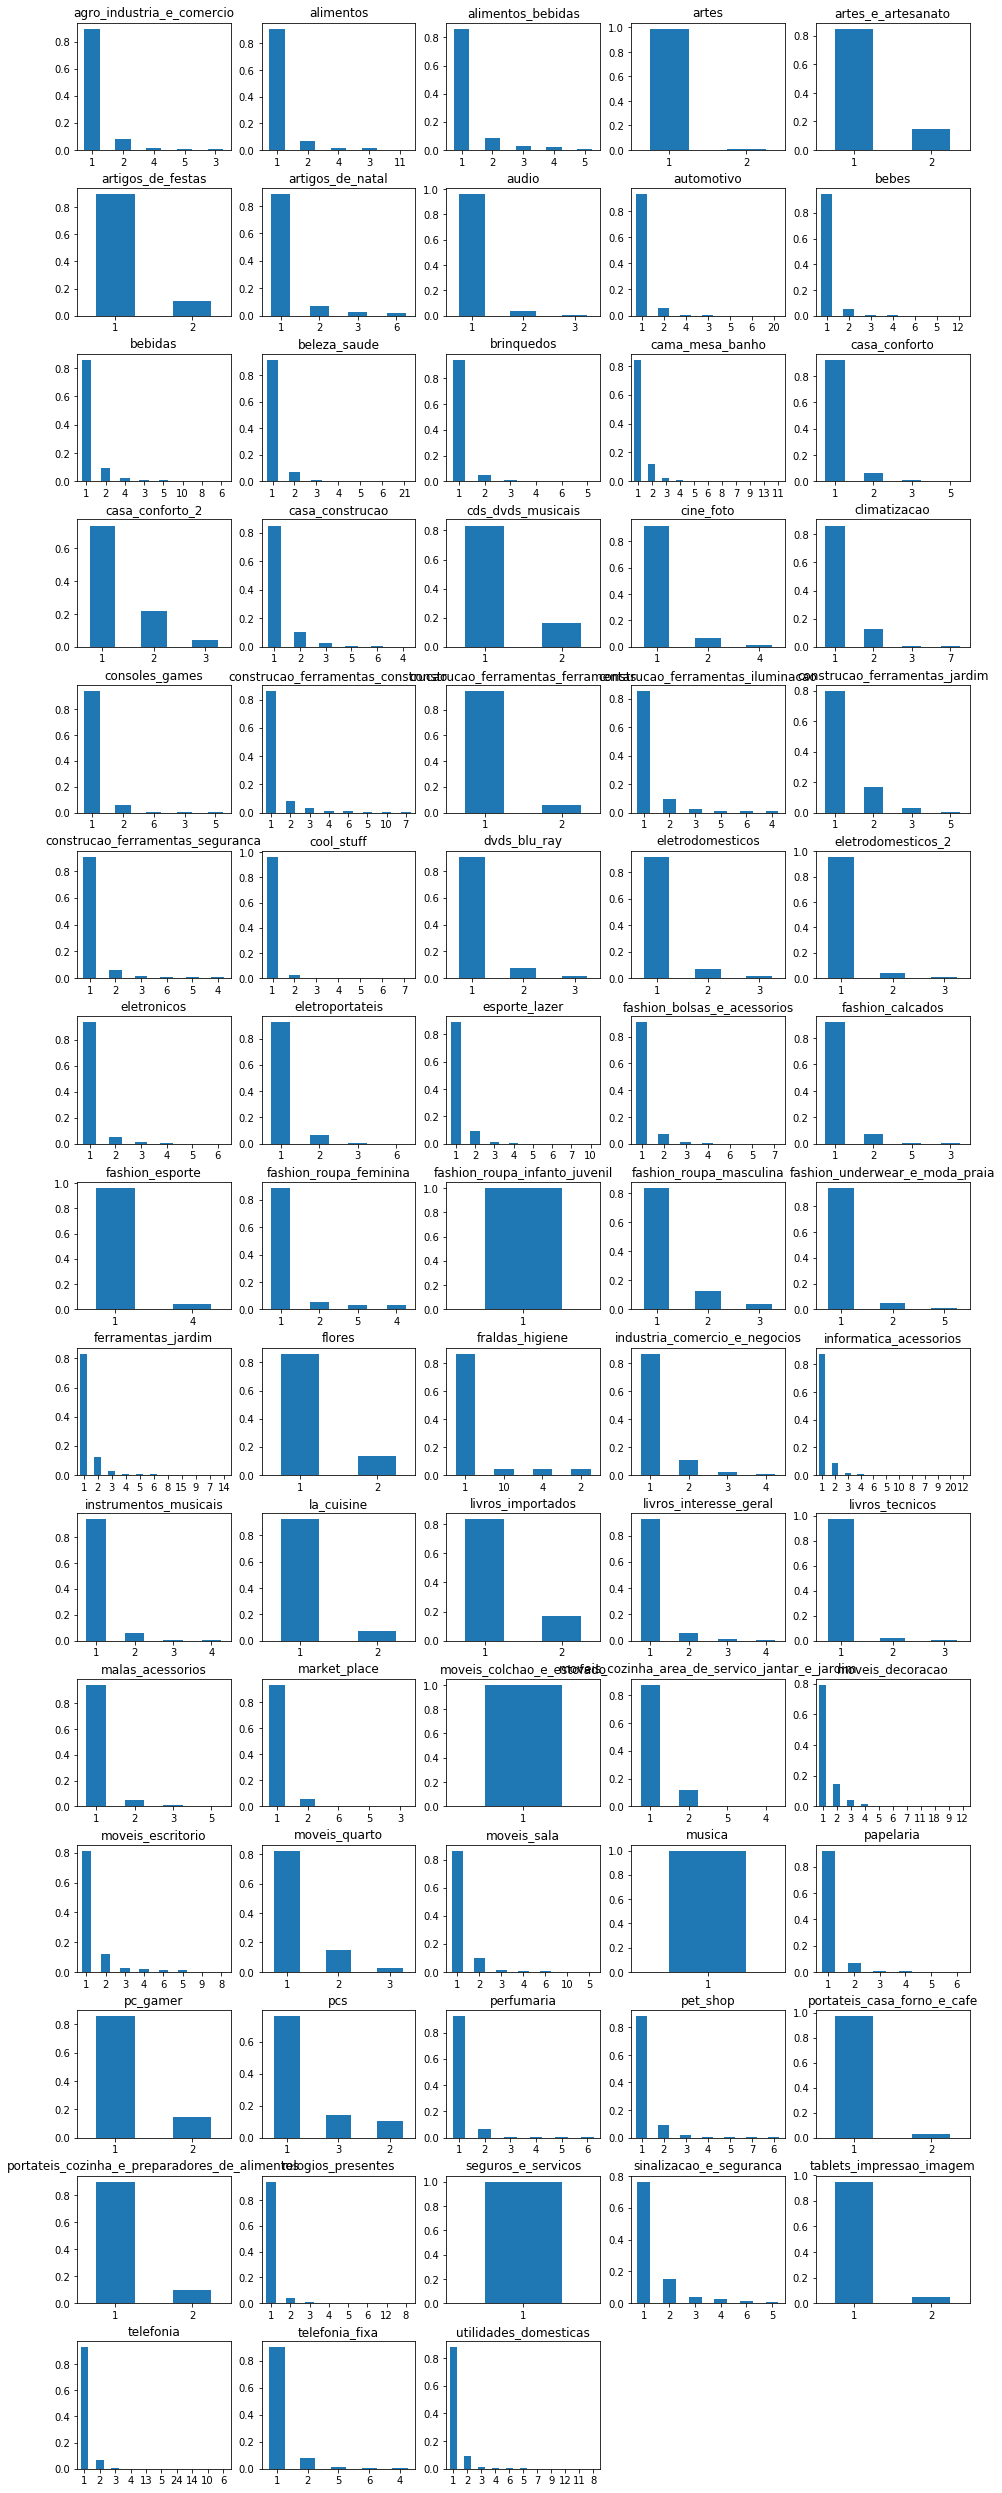

In [9]:
plt.figure(figsize=(16, 45))
plt.tight_layout()
plt.subplots_adjust(hspace=.3)

recurrence_by_category = pd.DataFrame(columns=['category', 'rate'])

for c in range(len(categories)):
    plt.subplot(15, 5, c + 1)
    customers = customers_by_category.loc[categories[c]].index
    orders_by_customers = all_orders[all_orders['customer_unique_id'].isin(customers.values)]
    sales_by_category = customers_by_category.loc[categories[c]].order_id
    
    recurrence_by_category.loc[categories[c]] = [
        categories[c],
        sales_by_category[sales_by_category.values > 2].count() / sales_by_category.count()
    ]
    
    plt.title(categories[c])
    sales_by_category.value_counts(normalize=True).plot.bar(rot=0)
    #print(sales_by_category.head())
    
display(Markdown('### Taxas de compras por categoria'))
plt.show()

In [10]:
recurrence_by_category.sort_values(by='rate', ascending=False).head()

,category,rate
pcs,pcs,0.137931
fraldas_higiene,fraldas_higiene,0.086957
sinalizacao_e_seguranca,sinalizacao_e_seguranca,0.086614
moveis_escritorio,moveis_escritorio,0.066606
moveis_decoracao,moveis_decoracao,0.066444


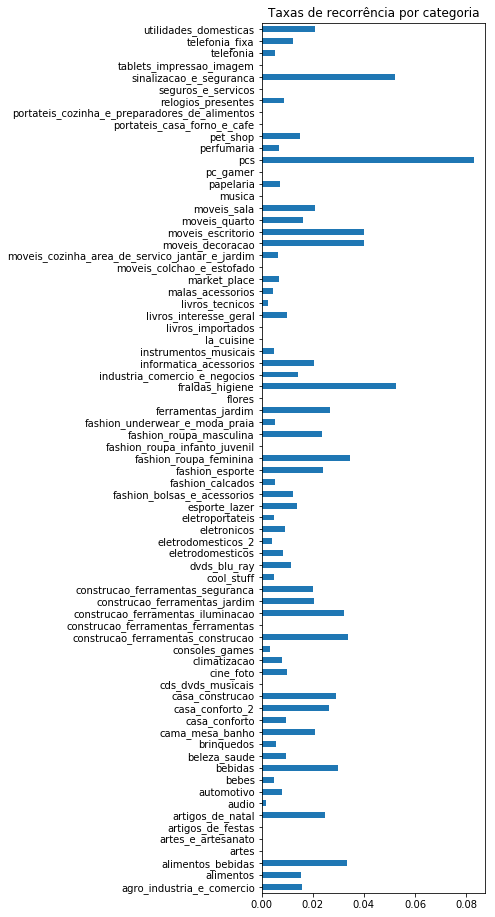

In [11]:
recurrence_distribution = (recurrence_by_category['rate'] / recurrence_by_category['rate'].sum()).sort_index()
recurrence_distribution.plot.barh(figsize=(4, 16))
plt.title('Taxas de recorrência por categoria')
plt.show()

In [12]:
print(recurrence_distribution.std() / recurrence_distribution.mean() * 100, '%', sep='')

111.56223366803192%


Visto que o desvio padrão é alto (111% da média), parece que, realmente, algumas categorias têm mais recorrência que outras.

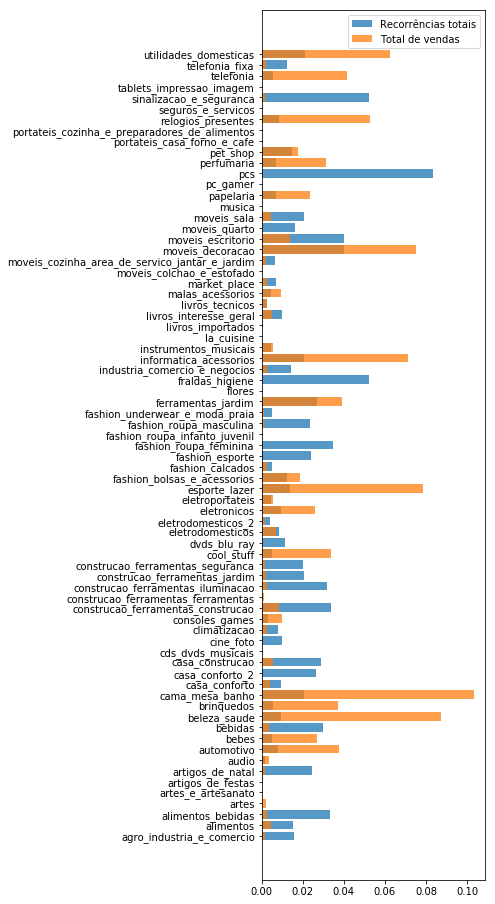

In [13]:
sales_by_category = orders_by_category.groupby('category').agg('count')['id']
sales_distribution = (sales_by_category / sales_by_category.sum()).sort_index()

plt.figure(figsize=(4, 16))
plt.barh(categories, recurrence_distribution, alpha=0.75)
plt.barh(categories, sales_distribution, alpha=0.75)
plt.legend(['Recorrências totais', 'Total de vendas'])
plt.show()

In [14]:
print(stats.kruskal(recurrence_distribution, sales_distribution).pvalue * 100, '%', sep='')

11.951872343331559%


O p-value de aproximadamente 12% indica que provavelmente a recorrência de compras entre as categorias não segue a mesma distribuição que o volume de compras.

Um maior volume de dados e uma janela de tempo mais abrangente ajudariam a dar respostas mais conclusivas nesse aspecto.